# OMPL Projection based sampling convergence for different robots

The projection method used in the experiments (from the OMPL source code) is:

```C++
bool ompl::base::Constraint::project(Eigen::Ref<Eigen::VectorXd> x) const
{
    // Newton's method
    unsigned int iter = 0;
    double norm = 0;
    Eigen::VectorXd f(getCoDimension());
    Eigen::MatrixXd j(getCoDimension(), n_);

    const double squaredTolerance = tolerance_ * tolerance_;

    function(x, f);
    while ((norm = f.squaredNorm()) > squaredTolerance && iter++ < maxIterations_)
    {
        jacobian(x, j);
        x -= j.jacobiSvd(Eigen::ComputeThinU | Eigen::ComputeThinV).solve(f);
        function(x, f);
    }

    return norm < squaredTolerance;
}
```

I used an `ompl::base::RealVectorStateSpace` for the uniform sampling, that has the bounds set to the robot's joint limits. This I project this state with the above method, for different settings of `maxIterations_`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_iter_vs_success_rate(filepath, robot_name):
    d = np.loadtxt(filepath, delimiter=",")
    fig, ax = plt.subplots()
    ax.plot(d[:, 0], 1 - d[:, 1] / d[:, 2])
    ax.set_title(f"{robot_name}", fontsize=16)
    ax.set_xlabel("Maximum number of iterations for projection", fontsize=14)
    ax.set_ylabel("Succes rate", fontsize=14)
    return fig, ax

def read_and_transform_error_data(filepath):
    d = np.loadtxt(filepath, delimiter=",");
    
    # there is data for different runs in the array
    # find out where each run started to split it up
    idx = list(np.where(np.diff(d[:, 0]) != 1)[0])
    
    # append the last index of the data to make processing easier
    idx.append(len(d[:, 0]) - 1)
    
    num_runs = len(idx)
    max_iters = int(np.max(d[:, 0]))
    dd = np.zeros((max_iters, num_runs))
    
    print(f"Found {num_runs} with maximum {max_iters} iterations")
    
    # transform the data from d (Nx2) -> dd (iters x runs)
    for i in range(len(idx) - 1):
        dd[0:idx[i+1]-idx[i], i] = d[idx[i]:idx[i+1], 1]
    
    return dd

def plot_error_data(data, robot_name):
    fig, ax = plt.subplots()
    ax.plot(dd, ".--")
    ax.set_title(f"{robot_name}", fontsize=14)
    ax.set_xlabel("Number of iterations for projection")
    ax.set_ylabel("Squared norm of constraint deviation")
    ax.set_xlim([0, data.shape[0]])
    return fig, ax

## Kuka KR5

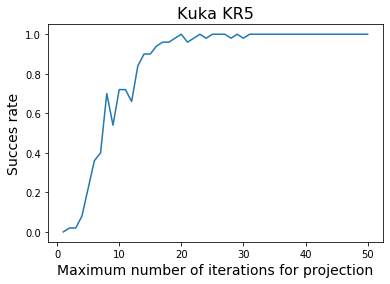

In [3]:
fig1, ax1 = plot_iter_vs_success_rate("data/kuka_kr5_projection.txt", "Kuka KR5")
plt.savefig("figures/kuka_kr5_results.png")

The error data contains a long list of pairs (index, error) for 10 runs in total. Below, we reorganize the data in a square matrix 10 x `max_iters`. For cases where convergence took less than `max_iters`, we leave it zero.

Found 10 with maximum 18 iterations


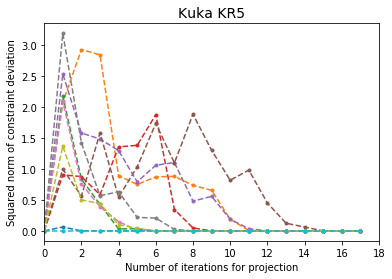

In [4]:
dd = read_and_transform_error_data("data/kuka_kr5_error.txt")
fig, ax = plot_error_data(dd, "Kuka KR5")
plt.savefig("figures/kuka_kr5_error.png")

## Fanuc

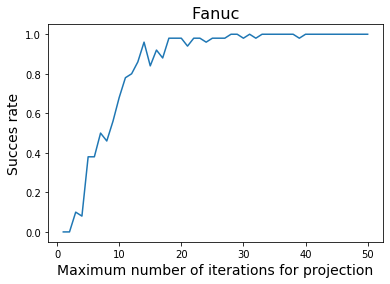

In [5]:
fig1, ax1 = plot_iter_vs_success_rate("data/fanuc_projection.txt", "Fanuc")

## Panda

Does not converge even after 1000 iterations.

```txt
100,10,10
200,10,10
300,10,10
400,10,10
500,10,10
600,10,10
700,10,10
800,10,10
900,10,10
1000,10,10
```

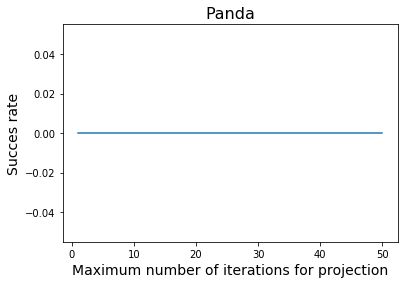

In [6]:
fig1, ax1 = plot_iter_vs_success_rate("data/panda_projection.txt", "Panda")

Found 10 with maximum 200 iterations


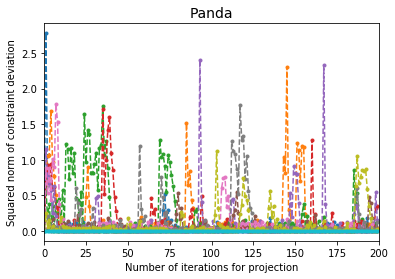

In [7]:
dd = read_and_transform_error_data("data/panda_error.txt")
fig, ax = plot_error_data(dd, "Panda")

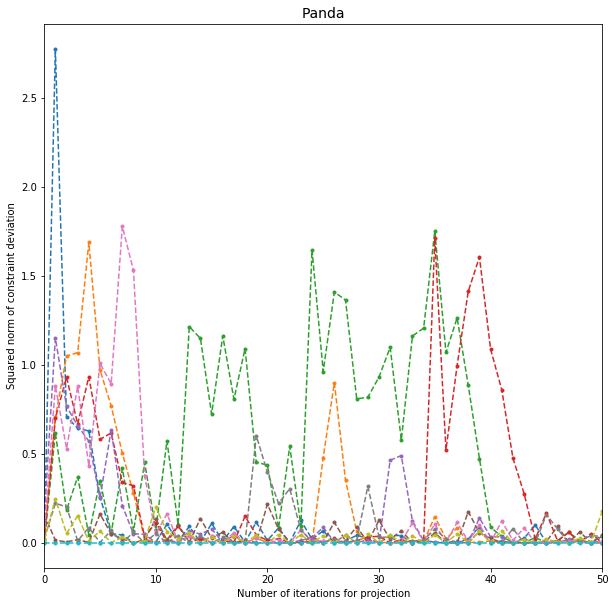

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(dd, ".--")
ax.set_title("Panda", fontsize=14)
ax.set_xlabel("Number of iterations for projection")
ax.set_ylabel("Squared norm of constraint deviation")
ax.set_xlim([0, 50])
plt.savefig("figures/panda_error.png")

## Create combined plot for all the robots

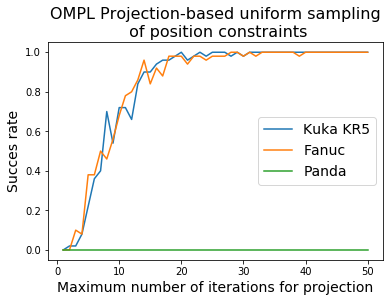

In [9]:
robots = ["Kuka KR5", "Fanuc", "Panda"]
filepaths = ["kuka_kr5_projection.txt", "fanuc_projection.txt", "panda_projection.txt"]
data = [np.loadtxt("data/" + path, delimiter=",") for path in filepaths]

fig, ax = plt.subplots()
for d in data:
    ax.plot(d[:, 0], 1 - d[:, 1] / d[:, 2])
ax.set_title("OMPL Projection-based uniform sampling\n of position constraints", fontsize=16)
ax.set_xlabel("Maximum number of iterations for projection", fontsize=14)
ax.set_ylabel("Succes rate", fontsize=14)
ax.legend(robots, fontsize=14)
plt.savefig("figures/sr_vs_max_iters.png", )